In [35]:
import pandas as pd
import sys
import os
from pathlib import Path
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from mlforecast import MLForecast
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae
sys.path.append(str(Path("..").resolve()))
from src.data.feature_engineering import date_features, lags, partial
from src.data.data_preprocessing import prepare_df
from utilsforecast.feature_engineering import pipeline, fourier
from functools import partial

## 1️⃣ Data preparation

In [36]:
# -------------------------------
# 1.1 Data Prepartion for Nixtla
# -------------------------------


raw_path =r'C:\Users\Guest\Desktop\ds-projects\Energy-Forecasting\data\raw\PJME_hourly.csv'


df= pd.read_csv(raw_path)  # raw CSV  
df = prepare_df(df)                      # clean, rename, add unique_id
df.head()

,ds,y,unique_id
8734,2002-01-01 01:00:00,30393.0,A
8735,2002-01-01 02:00:00,29265.0,A
8736,2002-01-01 03:00:00,28357.0,A
8737,2002-01-01 04:00:00,27899.0,A
8738,2002-01-01 05:00:00,28057.0,A


In [41]:
# -------------------------------
# 1.2 Split into train and test
# -------------------------------
split_date = '2017-01-01'

train = df[df['ds'] < split_date ]
test  = df[df['ds'] >= split_date ]

print(f'Train shape: {train.shape}, Test shape: {test.shape}')

Train shape: (131470, 3), Test shape: (13896, 3)


## Feature Engineering 

In [42]:
# -------------------------------
# 2. Apply exogenous features
# -------------------------------
# exg_features() returns list of feature functions (Fourier, etc.)




def exg_features():
    # Returns a list of partial functions for MLForecast
    return [partial(fourier, season_length=24, k=2)]


exg_df, future_df = pipeline(train, freq='h', h=len(test), features=exg_features())
print(f'Exogenous df shape: {exg_df.shape}')


Exogenous df shape: (131470, 7)


In [21]:
train.tail()

,ds,y,unique_id,sin1_24,sin2_24,cos1_24,cos2_24
122705,2016-12-31 19:00:00,34478.0,A,-1.000000,-0.000867,0.000434,-1.000000
122706,2016-12-31 20:00:00,33328.0,A,-0.965834,-0.500611,0.259160,-0.865672
122707,2016-12-31 21:00:00,32197.0,A,-0.865889,-0.866298,0.500236,-0.499528
122708,2016-12-31 22:00:00,30909.0,A,-0.706971,-1.000000,0.707242,0.000383
122709,2016-12-31 23:00:00,29519.0,A,-0.499904,-0.865914,0.866081,0.500192


In [22]:
test.head()

,ds,y,unique_id,sin1_24,sin2_24,cos1_24,cos2_24
122710,2017-01-01 00:00:00,28171.0,A,-0.258790,-0.499947,0.965934,0.866056
140207,2017-01-01 01:00:00,26879.0,A,-0.000050,-0.000100,1.000000,1.000000
140208,2017-01-01 02:00:00,25848.0,A,0.258693,0.499773,0.965960,0.866156
140209,2017-01-01 03:00:00,25039.0,A,0.499817,0.865814,0.866131,0.500366
140210,2017-01-01 04:00:00,24637.0,A,0.706900,1.000000,0.707313,0.000584


In [ ]:
len(test)

13896

## 2️⃣ Models Training

In [43]:
# ===============================
# 
# ===============================

models = {
                'lreg': LinearRegression(),
                'dt': DecisionTreeRegressor(),
                'xgb': xgb.XGBRegressor()
}


ml = MLForecast(
                freq='h',
                models=models,
                lags=[1, 24],
                date_features=['dayofweek', 'hour'],

)


In [44]:
ml.fit(train)

MLForecast(models=[lreg, dt, xgb], freq=h, lag_features=['lag1', 'lag24'], date_features=['dayofweek', 'hour'], num_threads=1)

In [45]:
pred_df = ml.predict(h=len(test), X_df=future_df)

In [40]:

cv_df = ml.cross_validation(
                h=50,
                df=train,
                n_windows=8,
                step_size=50,
                refit=True,
                static_features=[]
)
#print(f'cross validation results', cv_df.head())
print(f'✅ Models trained successfully!')
cv_df.head()

✅ Models trained successfully!


,unique_id,ds,cutoff,y,lreg,dt,xgb
0,A,2016-12-15 08:00:00,2016-12-15 07:00:00,39268.0,37138.943554,38761.0,38250.460938
1,A,2016-12-15 09:00:00,2016-12-15 07:00:00,39314.0,36914.588495,38616.0,38017.269531
2,A,2016-12-15 10:00:00,2016-12-15 07:00:00,39107.0,36415.933268,38721.0,37408.246094
3,A,2016-12-15 11:00:00,2016-12-15 07:00:00,39083.0,35778.253703,38907.0,37215.515625
4,A,2016-12-15 12:00:00,2016-12-15 07:00:00,39028.0,35071.312248,38297.0,36965.398438


In [ ]:

cv_df = ml.cross_validation(
                h=50,
                df=train,
                n_windows=8,
                step_size=50,
                refit=True,
                static_features=[]
)
#print(f'cross validation results', cv_df.head())
print(f'✅ Models trained successfully!')
cv_df.head()

✅ Models trained successfully!


,unique_id,ds,cutoff,y,lreg,dt,xgb
0,A,2016-12-15 08:00:00,2016-12-15 07:00:00,39268.0,37138.943554,38882.0,38250.460938
1,A,2016-12-15 09:00:00,2016-12-15 07:00:00,39314.0,36914.588495,38616.0,38017.269531
2,A,2016-12-15 10:00:00,2016-12-15 07:00:00,39107.0,36415.933268,38721.0,37408.246094
3,A,2016-12-15 11:00:00,2016-12-15 07:00:00,39083.0,35778.253703,39017.0,37215.515625
4,A,2016-12-15 12:00:00,2016-12-15 07:00:00,39028.0,35071.312248,38097.0,36965.398438


## 4️⃣ Evaluation and plotting

In [28]:
from utilsforecast.evaluation import evaluate


# Calculate performance metrics
metrics = evaluate(cv_df.drop(columns=['cutoff']),
                    metrics=[mae],
                    models=['lreg', 'dt', 'xgb']
            )

metrics

,unique_id,metric,lreg,dt,xgb
0,A,mae,2747.417911,3509.73,2370.146533


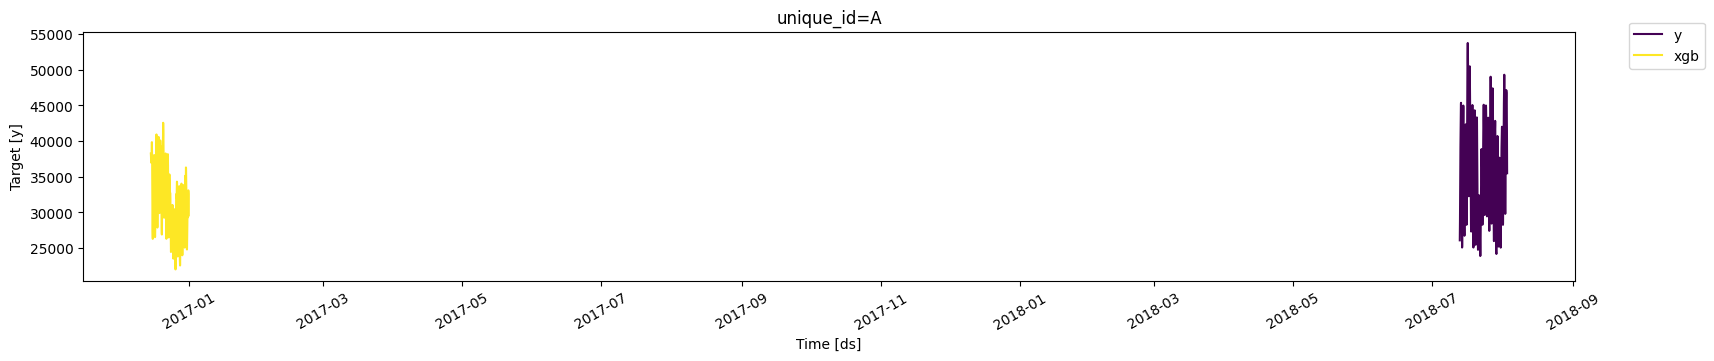

In [29]:
# 3.2 plotting

from utilsforecast.plotting import plot_series


plot_series(df=exg_df, 
                forecasts_df= cv_df.drop(columns=['cutoff', 'y']),
                max_insample_length=500,
                palette='viridis', 
                models=['xgb']
        )

In [43]:
import os
os.getcwd()

'c:\\Users\\Guest\\Desktop\\ds-projects\\Energy-Forecasting\\notbooks'